In [1]:
%load_ext autoreload
%autoreload 2

In [54]:
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
import seaborn as sns
import src.utils
import seaborn as sns
import matplotlib.pyplot as plt

from src.evaluation import (
    evaluate,
    encode_sequences,
    encode_sequence
    )
import src.config

import src.config
import src.data
import src.model_new
import src.utils
from src.model_new import (
    T5EncoderModelForTokenClassification,
)

import gc
import copy
import random

from transformers import (
    T5Tokenizer,
    DataCollatorForTokenClassification,
    TrainingArguments,
    Trainer,
    TrainerCallback
)

import peft
from peft import (
    LoraConfig,
)

In [3]:
ROOT = src.utils.get_project_root_path()
device = torch.device('cuda:0' if torch.cuda.is_available() else ('mps' if torch.backends.mps.is_available() else 'cpu'))

USE_CRF = True
EXPERT = 'SP'

SEED = 42
torch.manual_seed(42)
random.seed(42)
np.random.seed(42)

print("Base Model:\t", src.config.base_model_name)
print("MPS:\t\t", torch.backends.mps.is_available())
print("Path:\t\t", ROOT)
print(f"Using device:\t {device}")

Base Model:	 Rostlab/prot_t5_xl_uniref50
MPS:		 True
Path:		 /Users/finnlueth/Developer/gits/prottrans-t5-signalpeptide-prediction
Using device:	 mps


In [69]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)

In [79]:
FASTA_FILENAME = '5_SignalP_5.0_Training_set_testing.fasta'
df_data = src.data.process(src.data.parse_file(ROOT + '/data/raw/' + FASTA_FILENAME))
df_data = df_data[df_data['Partition_No'] == 4].reset_index(drop=True)
df_data['Sequence'] = df_data['Sequence'].apply(lambda x: x.replace(' ', ''))

In [82]:
df_data['Prediction'] = df_data['Label'].apply(lambda x: x)

In [84]:
df_data

,Uniprot_AC,Kingdom,Type,Partition_No,Sequence,Label,Prediction
0,P15647,ARCHAEA,NO_SP,4,MTETLPPVTESAVALQAEVTQRELFEFVLNDPLLASSLYINIALAGLSILLFVFMTRGLDDPRAKLIAVS,OOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOMMMMMMMMMMMMMMMMMMMMMMIIIIIIIMMMMM,OOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOMMMMMMMMMMMMMMMMMMMMMMIIIIIIIMMMMM
1,D4GYH0,ARCHAEA,NO_SP,4,MKRLAKAAFSQNSLTAPIVSTFVYLISVVRVVLNGNWPVTSSDTAMFQHIGWMVFSGKRYYIDAWDPKPP,IIIIIIIIIIIIMMMMMMMMMMMMMMMMMMMMMOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOO,IIIIIIIIIIIIMMMMMMMMMMMMMMMMMMMMMOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOO
2,P42844,EUKARYA,NO_SP,4,MIPRTRTLLQSKIPITRYFARCWAPRVRYNVCRTLPAAALHTNIIAHNEVKKDDKKVHLGSFKVDKPKMM,IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII,IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII
3,P52569,EUKARYA,NO_SP,4,MIPCRAALTFARCLIRRKIVTLDSLEDTKLCRCLSTMDLIALGVGSTLGAGVYVLAGEVAKADSGPSIVV,IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIMMMMMMMMMMMMMMMMMMMMMMOOOOMMMMMMM,IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIMMMMMMMMMMMMMMMMMMMMMMOOOOMMMMMMM
4,Q02219,NEGATIVE,LIPO,4,MKRQALAAMIASLFALAACGGEQAAQAPAETPAASAEAASSAAQATAETPAGELPVIDAVTTHAPEVPPA,LLLLLLLLLLLLLLLLLLOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOO,LLLLLLLLLLLLLLLLLLOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOO
5,P28607,NEGATIVE,LIPO,4,MQKISIIFNLFLSLGCLAFTFNGSASETKNEWITLGTMAGPIPNAKHSQPANAMLVNGNTYVVDAGDGTA,LLLLLLLLLLLLLLLOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOO,LLLLLLLLLLLLLLLOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOO
6,Q9PR09,NEGATIVE,LIPO,4,MKLNKKHLVAILSVLSLSIIVVPLLTSCTGDIPELNPAEIINTLFPNVWVFIAQVIAMCVVFSLVLWLVW,LLLLLLLLLLLLLLLLLLLLLLLLLLLOOOOOOOOOOOOOOOOOOOOMMMMMMMMMMMMMMMMMMMMMII,LLLLLLLLLLLLLLLLLLLLLLLLLLLOOOOOOOOOOOOOOOOOOOOMMMMMMMMMMMMMMMMMMMMMII
7,Q8Z2M4,NEGATIVE,TAT,4,MKNKDSLHVSRRRFLAQLGGLTVAGMLGPSLLTPRSARAADAVAPGAATKEGILTGSHWGAIRATVVDGR,TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOO,TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOO
8,P84888,NEGATIVE,SP,4,MKSKFKLTTAAAMLGLMVLAGGAQAQDKPREVLTGGHSVSAPQENRIYVMDSV,SSSSSSSSSSSSSSSSSSSSSSSSSOOOOOOOOOOOOOOOOOOOOOOOOOOOO,SSSSSSSSSSSSSSSSSSSSSSSSSOOOOOOOOOOOOOOOOOOOOOOOOOOOO
9,P39180,NEGATIVE,SP,4,MKRHLNTCYRLVWNHMTGAFVVASELARARGKRGGVAVALSLAAVTSLPVLAADIVVHPGETVNGGTLAN,SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSOOOOOOOOOOOOOOOOOO,SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSOOOOOOOOOOOOOOOOOO


In [91]:
df_data[df_data['Type'] == 'LIPO']['Prediction'] = df_data[df_data['Type'] == 'LIPO']['Prediction'].apply(lambda x: 1)

/var/folders/c3/ctxqsv450b3cgzj3sklngdm80000gn/T/ipykernel_42380/3421592091.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_data[df_data['Type'] == 'LIPO']['Prediction'] = df_data[df_data['Type'] == 'LIPO']['Prediction'].apply(lambda x: 1)


In [92]:
df_data

,Uniprot_AC,Kingdom,Type,Partition_No,Sequence,Label,Prediction
0,P15647,ARCHAEA,NO_SP,4,MTETLPPVTESAVALQAEVTQRELFEFVLNDPLLASSLYINIALAGLSILLFVFMTRGLDDPRAKLIAVS,OOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOMMMMMMMMMMMMMMMMMMMMMMIIIIIIIMMMMM,OOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOMMMMMMMMMMMMMMMMMMMMMMIIIIIIIMMMMM
1,D4GYH0,ARCHAEA,NO_SP,4,MKRLAKAAFSQNSLTAPIVSTFVYLISVVRVVLNGNWPVTSSDTAMFQHIGWMVFSGKRYYIDAWDPKPP,IIIIIIIIIIIIMMMMMMMMMMMMMMMMMMMMMOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOO,IIIIIIIIIIIIMMMMMMMMMMMMMMMMMMMMMOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOO
2,P42844,EUKARYA,NO_SP,4,MIPRTRTLLQSKIPITRYFARCWAPRVRYNVCRTLPAAALHTNIIAHNEVKKDDKKVHLGSFKVDKPKMM,IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII,IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII
3,P52569,EUKARYA,NO_SP,4,MIPCRAALTFARCLIRRKIVTLDSLEDTKLCRCLSTMDLIALGVGSTLGAGVYVLAGEVAKADSGPSIVV,IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIMMMMMMMMMMMMMMMMMMMMMMOOOOMMMMMMM,IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIMMMMMMMMMMMMMMMMMMMMMMOOOOMMMMMMM
4,Q02219,NEGATIVE,LIPO,4,MKRQALAAMIASLFALAACGGEQAAQAPAETPAASAEAASSAAQATAETPAGELPVIDAVTTHAPEVPPA,LLLLLLLLLLLLLLLLLLOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOO,LLLLLLLLLLLLLLLLLLOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOO
5,P28607,NEGATIVE,LIPO,4,MQKISIIFNLFLSLGCLAFTFNGSASETKNEWITLGTMAGPIPNAKHSQPANAMLVNGNTYVVDAGDGTA,LLLLLLLLLLLLLLLOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOO,LLLLLLLLLLLLLLLOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOO
6,Q9PR09,NEGATIVE,LIPO,4,MKLNKKHLVAILSVLSLSIIVVPLLTSCTGDIPELNPAEIINTLFPNVWVFIAQVIAMCVVFSLVLWLVW,LLLLLLLLLLLLLLLLLLLLLLLLLLLOOOOOOOOOOOOOOOOOOOOMMMMMMMMMMMMMMMMMMMMMII,LLLLLLLLLLLLLLLLLLLLLLLLLLLOOOOOOOOOOOOOOOOOOOOMMMMMMMMMMMMMMMMMMMMMII
7,Q8Z2M4,NEGATIVE,TAT,4,MKNKDSLHVSRRRFLAQLGGLTVAGMLGPSLLTPRSARAADAVAPGAATKEGILTGSHWGAIRATVVDGR,TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOO,TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOO
8,P84888,NEGATIVE,SP,4,MKSKFKLTTAAAMLGLMVLAGGAQAQDKPREVLTGGHSVSAPQENRIYVMDSV,SSSSSSSSSSSSSSSSSSSSSSSSSOOOOOOOOOOOOOOOOOOOOOOOOOOOO,SSSSSSSSSSSSSSSSSSSSSSSSSOOOOOOOOOOOOOOOOOOOOOOOOOOOO
9,P39180,NEGATIVE,SP,4,MKRHLNTCYRLVWNHMTGAFVVASELARARGKRGGVAVALSLAAVTSLPVLAADIVVHPGETVNGGTLAN,SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSOOOOOOOOOOOOOOOOOO,SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSOOOOOOOOOOOOOOOOOO


In [53]:
# [len(x) for x in df_data['Prediction'].value_counts().index]

In [4]:
# targets = [
#     'SSSOTLTMLLLOOTSOOOLMTLMOLTLLMMLLLSLLSSSSOOOTTMSIOMITTITIOIITOTOTTLSTOTM',
#     'IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIMMMMMMMMIIIIIIIIIIIIMIIIMMIIIMIIIL',
#     'IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIMMMMMMMMIIIIIIIIIIIIMIIIMMIIIMIIIL'
#     ]
# predictions = [
#     'SSSOTLTMLLLOOTSOOOLMTLMOLTLLMMLLLSLLSSSSOOOTTMSIOMITTITIOIITOTOTTLSTOTM',
#     'MIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIMMMMMMMMIIIIIIIIIIIIMIIIMMIIIMIIIL',
#     'IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIMMMMMMMMIIIIIIIIOSTIMIIIMMIIIMIIIL'
#     ]


# predictions = encode_sequences(predictions, encoding=src.config.label_encoding)
# targets = encode_sequences(targets, encoding=src.config.label_encoding)

In [55]:
target =        'IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIMMMMMMMMIIIIIIIIIIIIMIIIMMIIIMIIIL'
prediction =    'IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIMMMMMMMMIIIIIIIIOSTIMIIIMMIIIMIIIL'

target = encode_sequence(target, encoding=src.config.label_encoding)
prediction = encode_sequence(prediction, encoding=src.config.label_encoding)

In [58]:
evaluation = evaluate(
    predictions=prediction,
    targets=target,
    encoding=src.config.label_encoding,
    decoding=src.config.label_decoding
)

/Users/finnlueth/Developer/gits/prottrans-t5-signalpeptide-prediction/src/evaluation.py:33: RuntimeWarning: invalid value encountered in divide
  TPR = TP/(TP+FN)
/Users/finnlueth/Developer/gits/prottrans-t5-signalpeptide-prediction/src/evaluation.py:38: RuntimeWarning: invalid value encountered in divide
  FNR = FN/(TP+FN)
/Users/finnlueth/Developer/gits/prottrans-t5-signalpeptide-prediction/src/evaluation.py:46: RuntimeWarning: invalid value encountered in divide
  MCC_2 = (TP*TN-FP*FN)/np.sqrt((TP+FP)*(TP+FN)*(TN+FP)*(TN+FN))


In [59]:
df_evaluation = pd.DataFrame(evaluation)

In [60]:
df_evaluation_MCC = pd.DataFrame(df_evaluation['MCC_2'].to_list(), columns=src.config.label_encoding)
df_evaluation_MCC_mean = pd.DataFrame(np.nanmean(df_evaluation_MCC, axis=0).reshape(-1, 6), columns=src.config.label_encoding)
df_evaluation_MCC_dev = pd.DataFrame(np.std(df_evaluation_MCC, axis=0)).T
df_evaluation_MCC_error = pd.DataFrame(np.std(df_evaluation_MCC, axis=0, ddof=1)).T
display(df_evaluation_MCC, df_evaluation_MCC_mean, df_evaluation_MCC_error)
# display(df_evaluation_MCC)

/var/folders/c3/ctxqsv450b3cgzj3sklngdm80000gn/T/ipykernel_42380/2643159137.py:2: RuntimeWarning: Mean of empty slice
  df_evaluation_MCC_mean = pd.DataFrame(np.nanmean(df_evaluation_MCC, axis=0).reshape(-1, 6), columns=src.config.label_encoding)


,I,L,M,O,S,T
0,0.877767,1.0,1.0,NaN,NaN,NaN


,I,L,M,O,S,T
0,0.877767,1.0,1.0,NaN,NaN,NaN


,I,L,M,O,S,T
0,NaN,NaN,NaN,NaN,NaN,NaN


<Axes: title={'center': 'MCC Error'}, xlabel='Labels', ylabel='Error'>

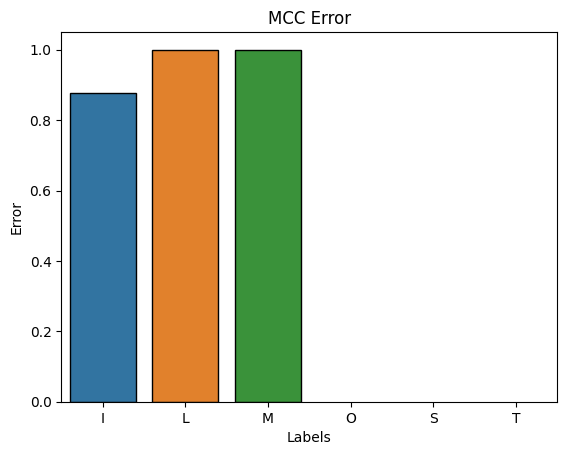

In [61]:
src.evaluation.plot_mcc(df_evaluation_MCC)

<Axes: title={'center': 'Confusion Matrix'}, xlabel='Actual', ylabel='Predicted'>

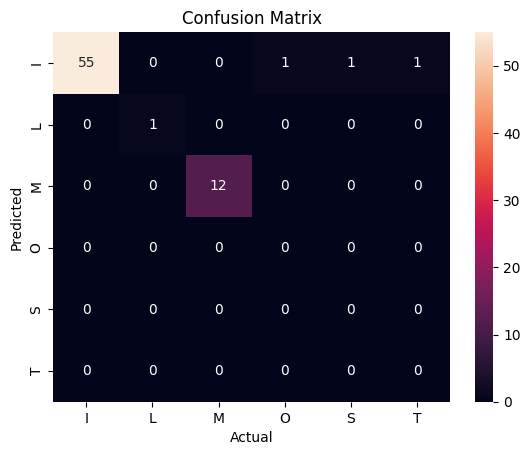

In [62]:
src.evaluation.plot_confusion_matrix(df_evaluation['CM'].sum(), src.config.label_decoding)

In [ ]:
FASTA_FILENAME = '5_SignalP_5.0_Training_set.fasta'
# FASTA_FILENAME = '5_SignalP_5.0_Training_set_testing.fasta'
df_data = src.data.process(src.data.parse_file(ROOT + '/data/raw/' + FASTA_FILENAME))

In [ ]:
df_data.shape

In [ ]:
df_data[df_data['Sequence'].str.startswith('M A A V I L E R L G A L W V Q N L R G K L A L G I L P Q')]

In [ ]:
'M M M M M M M M M M M M M M M M M M M M M M M M M M M M M M M M M M M M M M M M M M M M M M M M M M M M M M M M M M M M M M M M M M M M M M M'.replace(' ', '')

In [ ]:
df_data